# COMPUTATIONAL COGNITIVE SCIENCE

<div class="alert alert-success">
    Pulkit Goyal and Joel Vasama
</div>

# Abstract

# Introduction

# `Analysis`

## Imports

In [213]:
import sys

In [214]:
from functools import lru_cache

---

In [215]:
import numpy as np

In [216]:
import pandas as pd

In [217]:
from scipy import optimize
import scipy.stats as st

In [308]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

---

In [219]:
import matplotlib.pyplot as plt

In [220]:
import seaborn as sns

---

In [221]:
from tqdm import tqdm

In [222]:
from IPython.display import display

---

In [223]:
import warnings
warnings.filterwarnings("ignore")

## Data Reading and Pre-Processing

In [224]:
data = pd.read_csv('ccs2022.csv')
data.rename(columns={'Unnamed: 0':'semi_global_trial'}, inplace=True)

In [225]:
# Check for empty values
data.isna().any();

In [226]:
# Add column to mark when J is the correct response
data['J_correct'] = (data['yj'] > data['yf']).astype(int)

In [227]:
# Add column to mark when a correct choice was made
data['correct'] = (data['J_correct'] == data['J_pressed']).astype(int)

In [228]:
# Create unique task identifier for all participants
data['global_task'] = 100*data['slow'] + data['task']

In [360]:
# Create second unique task identifier for all participants
data['global_task_2'] = list(np.repeat(range(1,31), 10)) * 19

In [229]:
data.head()

,semi_global_trial,num_features,task,trial,w0,w1,w2,w3,xf0,xf1,...,xj3,yf,yj,slow,J_pressed,decision_time,participant_id,J_correct,correct,global_task
0,0,2,1,1,-0.442305,-1.614365,0.0,0.0,0.151539,-0.325901,...,0.0,0.459097,1.784513,1,1,2555,0,1,1,101
1,1,2,1,2,-0.442305,-1.614365,0.0,0.0,-1.500723,0.559236,...,0.0,-0.239034,-1.642405,1,1,1203,0,0,0,101
2,2,2,1,3,-0.442305,-1.614365,0.0,0.0,0.398691,0.523985,...,0.0,-1.022246,0.896446,1,1,813,0,1,1,101
3,3,2,1,4,-0.442305,-1.614365,0.0,0.0,0.715695,-0.925789,...,0.0,1.178006,4.049918,1,1,917,0,1,1,101
4,4,2,1,5,-0.442305,-1.614365,0.0,0.0,2.294209,1.454999,...,0.0,-3.363640,-2.712185,1,1,1278,0,1,1,101


## Global Constants

In [ ]:
NUM_TRIALS = data['trial'].nunique()

In [ ]:
NUM_PARTICIPANTS = data['participant_id'].nunique()
PARTICIPANTS = data['participant_id'].unique().astype(int)

---

In [ ]:
PRINT_ENABLE = False

## Global Functions

### Miscellaneous

In [233]:
def detect_outliers(x):
    q1 = np.quantile(x, 0.25) # Lower quartile
    q3 = np.quantile(x, 0.75) # Upper quartile
    
    iqr = q3-q1 # Interquartile range
    
    iqr_bounds = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)] # Bounds
    
    outliers = x[(x <= iqr_bounds[0]) | (x >= iqr_bounds[1])] # Selecting data beyond bounds
    
    return outliers

In [234]:
def print_(*args, **kwargs):
    if PRINT_ENABLE:
        print(*args, **kwargs)

In [381]:
def save(arr, folder='./pickles'):
    np.save(f'{folder}/{arr}', globals()[arr], allow_pickle=True)

In [386]:
def load(arr, folder='./pickles'):
    return np.load(f'{folder}/{arr}.npy')

### Plotting

In [347]:
def boxplots(a, box_labels, ax, point_labels=PARTICIPANTS, title=None):
    df = pd.DataFrame(np.array([np.array(a_i).flatten() for a_i in a]).T, columns=box_labels)
    sns.boxplot(data=df, ax=ax, boxprops=dict(alpha=.3))
    sns.swarmplot(data=df, ax=ax)

    for i, k in enumerate(point_labels):
        for j, a_i in enumerate(a):
            ax.text(j, a_i[i], k, alpha=0.8)
    
    if title: ax.set_title(title)

### Decision Making

In [237]:
epsilon_greedy = lambda choice_function: lambda e: lambda *args, **kwargs: choice_function(*args, **kwargs) * (1 - e) + 0.5 * e

In [238]:
@epsilon_greedy
def softmax(s1, s2, *std): # Softmax Rule
    return 1/(1 + np.e**(s1 - s2))

In [239]:
@epsilon_greedy
def am(s1, s2, *std): # Accuracy Maximization
    return s1 < s2

In [240]:
@epsilon_greedy
def pm(s1, s2, std1, std2): # Probability Matching
    return np.random.normal(s1, std1) < np.random.normal(s2, std2)

In [241]:
@epsilon_greedy
def sb(s1, s2, std1, std2, n_samples=10): # Sample Based Decision
    return np.count_nonzero(np.random.normal(s1, std1, (1, n_samples)) > np.random.normal(s2, std2, (1, n_samples))) >= n_samples/2

### Scoring

In [242]:
# Bayesian Information Criterion
# > BIC = p.ln(t.k) - 2.LL
bic = lambda P, N, LL: P*np.log(N) - 2*LL

In [243]:
# Akaike Information Criterion
# > AIC = 2.p - 2.LL
aic = lambda P, N, LL: 2*P - 2*LL

### Model Fitting

In [244]:
# @lru_cache
def fit_model(participant_id,
              Model,
              model_params,
              choice_function=am(0),
              conditions={},
              feature_labels=[['xf0', 'xf1', 'xf2', 'xf3'], ['xj0', 'xj1', 'xj2', 'xj3']],
              target_labels=[['yf'], ['yj']],
              choice_label='J_pressed'):

    data_participant = data[data['participant_id'] == participant_id]
    if conditions:
        for condition in conditions:
            data_participant = data_participant[data_participant[condition] == conditions[condition]]

    ## num_tasks = data_participant['global_task'].nunique() # Find number of tasks
    tasks = data_participant['global_task'].unique() # Find the tasks that satisfy the conditions
    if not len(tasks):
        raise ValueError('No tasks with the given conditions.')

    log_likelihoods = {} # [num_tasks]
    for task in tasks: # For each task
        data_participant_task = data_participant[data_participant['global_task'] == task] # Focus on that task data

        num_features = int(data_participant_task['num_features'].unique()) # Find number of inputs for that task
        
        model = Model(num_features, *model_params) # Create Model instance with the number of inputs and passed model parameters

        log_likelihood = []
        for trial in data_participant_task['trial'].unique(): # For each trial
            data_participant_task_trial = data_participant_task[data_participant_task['trial'] == trial] # Focus on that trial data

            # Extract input and target arrays, and choice, using (default) labels passed in function call
            inputs = [data_participant_task_trial[feature_labels_i[:num_features]].to_numpy().reshape((-1, 1)) for feature_labels_i in feature_labels]
            targets = [data_participant_task_trial[target_labels_i].to_numpy().reshape((-1, 1)) for target_labels_i in target_labels]

            # Make predictions
            means, std = np.array([np.array(model.predict(inputs_i)).flatten() for inputs_i in inputs]).T

            # Learn model
            for inputs_i, target in zip(inputs, targets):
                model.learn(inputs_i, target)

            # Make decision
            p_choice = choice_function(*means, *std)

            likelihood = p_choice if int(data_participant_task_trial[choice_label]) == 1 else 1-p_choice
            
            # Calculate log-likelihood
            log_likelihood.append(np.log(likelihood if likelihood else sys.float_info.min)) # corresponding to the lowest log(float) possible

        log_likelihoods[task] = log_likelihood

    return log_likelihoods

In [245]:
def pick_tasks(participant_id, conditions={}): # {'num_features': 2}, {'num_features': 3}, {'num_features': 4}, {'slow': 1}, {'slow': 0}
    # def create_condition(key, param):
    #     if key == 'all':
    #         return []
    #     else:
    #         try:
    #             return {key: int(param)}
    #         except ValueError:
    #             raise ValueError('Invalid Condition!')

    data_participant = data[data['participant_id'] == participant_id]
    
    if conditions: # If there are conditions
        for condition in conditions: # Apply conditions iteratively
            data_participant = data_participant[data_participant[condition] == conditions[condition]]
    
    tasks = data_participant['global_task'].unique() # Find the tasks that satisfy the conditions
    
    if not len(tasks):
        raise ValueError('No tasks with the given conditions.')

    return tasks

### Optimizing

In [246]:
def no_search(func, rrange):
    return np.arange(*rrange[0])[0], func(np.arange(*rrange[0])[:1])

In [339]:
def optimise(Model,
             model_search_space=(),
             search_algorithm=lambda *args, **kwargs: optimize.brute(*args, **kwargs, full_output=True, finish=None),
             error_search_space=(0, 1, 0.1),
             choice_function=softmax,
             xic=bic,
             conditions={}):
    
    if len(model_search_space) != Model._num_params:
        raise ValueError(f'Not enough model search parameters specified. Required {Model._num_params} parameters.')
    
    xics = []
    optimal_model_params = []
    optimal_error = []
        
    for participant_id in tqdm(data['participant_id'].unique()):
        tasks = pick_tasks(participant_id, conditions)

        def llfunc(model_error_params):
            log_likelihoods = fit_model(participant_id, Model, tuple(model_error_params)[:-1], choice_function(model_error_params[-1]), conditions)
            return -sum([sum(log_likelihoods[task]) for task in tasks])
        
        optimal_model_error_params, fval, *_ = search_algorithm(llfunc, model_search_space + (error_search_space,))
        
        xics.append(xic(len(model_search_space)+1, len(tasks)*NUM_TRIALS, -fval))
        optimal_model_params.append(optimal_model_error_params[:-1])
        optimal_error.append(optimal_model_error_params[-1])
    
    return np.array(xics), np.array(optimal_model_params), np.array(optimal_error)

## Outlier Detection

The most important columns for analysis are participant accuracy and reaction time as these reflect performance in the experiment.

`Outlier Detection (Accuracy)`

In [248]:
# Average accuracy
avg_correct = data['correct'].mean()
print_(f'Average accuracy: {avg_correct:.3f}')

In [249]:
# Participant accuracy
par_correct = data.groupby('participant_id')['correct'].mean()
print_(par_correct.to_frame())

In [250]:
print_(detect_outliers(par_correct))

`Outlier Detection (Reaction Time)`

In [251]:
par_RT = data.groupby('participant_id')['decision_time'].mean()
print_(par_RT.to_frame())

In [252]:
print_(detect_outliers(par_RT));

---

`Outlier Detection | Summary`

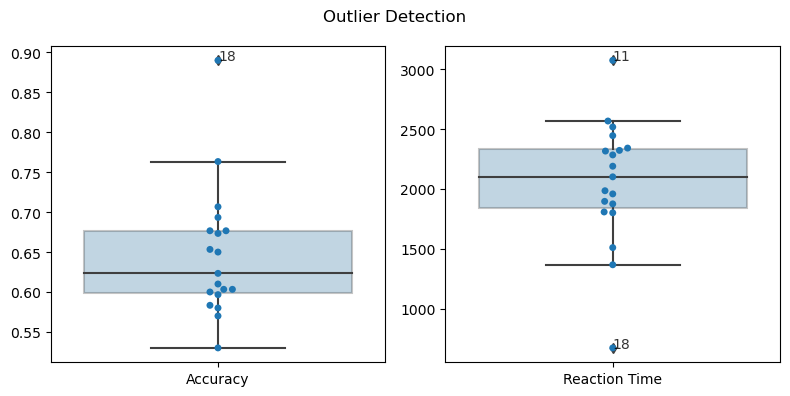

In [399]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
boxplots([par_correct], ['Accuracy'], ax[0], point_labels=['']*11 + [''] + ['']*6 + [18])
boxplots([par_RT], ['Reaction Time'], ax[1], point_labels=['']*11 + [11] + ['']*6 + [18])
fig.suptitle('Outlier Detection')
plt.tight_layout()

We also note two outliers in reaction time data, with participants 18 and 11 having exceptionally fast and slow reaction times, respectively.

After taking a look at the accuracy data we found one outlier performing well above others. We identify this as participant number 18.

### Excluding Outliers

We decided to exclude only participant 18 due to having both higher accuracy and lower RT than all other participants. However, we keep participant 11 in the data as despite their slow reaction times their performance was not exceptional.

In [42]:
data_ = data[data['participant_id'] != 18] # Excluding participant 18

In [43]:
# Computing new means after exclusion
avg_correct = data_['correct'].mean()
par_correct = data_.groupby('participant_id').correct.mean()
par_RT = data_.groupby('participant_id').decision_time.mean()

## Behavioral Analysis

#### Do participants perform better than chance?

In [ ]:
print_(f'Average accuracy: {avg_correct}')
t_par, p_par = st.ttest_1samp(par_correct, 0.5)
print_(f't = {t_par} ; p = {p_par}')

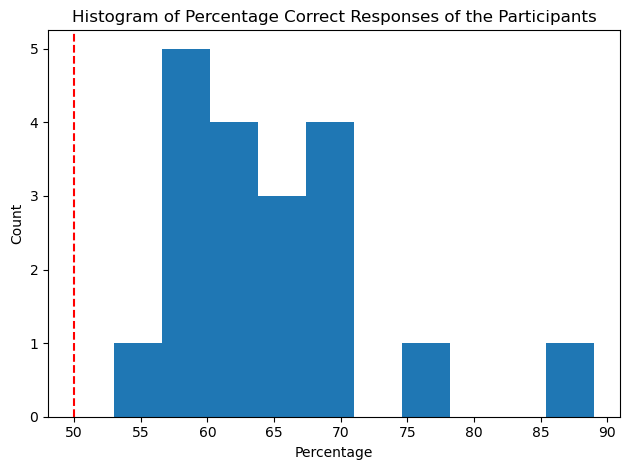

In [410]:
plt.hist(par_correct*100)
plt.axvline(50, c='r', linestyle='--')

plt.title('Histogram of Percentage Correct Responses of the Participants')
plt.xlabel('Percentage')
plt.ylabel('Count')

plt.tight_layout()

A one-sample t-test against a 50% chance level (participants had two alternatives) reveals that participants performed statistically significantly above chance level ($t$ = 9.75, $p$ < 0.05) with an average accuracy of 63.3%.

#### Do they improve over trials within each round?

In [45]:
data_.groupby('trial').correct.mean();

In [46]:
smf.ols(formula='correct ~ trial', data=data_).fit().summary();

A linear regression analysis indicated that participants performed better trial-wise within blocks ($\beta$ = 0.014, $R^2$ = 0.007, $p$ < 0.001), performing on average 1.4% better each trial after the first.

#### Do they improve over rounds?

In [47]:
data_.groupby(['task', 'slow']).correct.mean();

In [48]:
smf.ols(formula='correct ~ task', data=data_).fit().summary();

We also performed a linear regression analysis to test whether participants performed better at the start of the experiment but found no statistically significant influence of task ($p$ = 0.242).

#### How does the number of observed features affect performance?

In [49]:
data_.groupby('num_features').correct.mean();

In [278]:
smf.ols(formula='correct ~ num_features', data=data_).fit().summary();

We found that the number of features has a statistically significant influence on participant accuracy ($\beta$ = -0.043, $R^2$ = 0.005, $p$ < 0.001), with the addition of each feature decreasing accuracy on average by 4.3%.

#### How does time pressure affect performance?

In [51]:
data_.groupby('slow').correct.mean();

In [52]:
t_slow_fast, p_slow_fast = st.ttest_rel(data_[data_['slow'] == 0].correct, data_[data_['slow'] == 1].correct)
print_(f't = {t_slow_fast}, p = {p_slow_fast}')

Participants also had better accuracy in slow trials over regular trials as indicated by an independent samples t-test ($df$ = 17, $t$ = -3.5, $p$ < 0.001), performing on average 4.5% better in slow trials.

---

### Does RT affect performnce?

In [53]:
data_.groupby('participant_id')[['decision_time', 'correct']].mean();

In [54]:
st.pearsonr(par_correct, par_RT);

In [55]:
smf.ols(formula='correct ~ num_features * C(slow) * decision_time', data=data_).fit().summary();

We found a significant negative relationship between accuracy and reaction time.

---

### Bigression

In [56]:
smf.ols(formula='correct ~ num_features * C(slow) * decision_time', data=data_).fit().summary();

## Parameter Fitting

`Look at the resulting parameters and try to answer the following questions`

### Rescorla-Wagner

In [57]:
class RescorlaWagner():
    _num_params = 1

    def __init__(self, num_features, learning_rate):
        self.num_features = num_features
        self.learning_rate = learning_rate
        
        self.weights = np.zeros((num_features, 1))
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        return mean, [[0]]
        
    def learn(self, inputs, targets):
        self.weights = self.weights + self.learning_rate * (targets - self.weights.T @ inputs) * inputs

In [59]:
# bics_rw_slow, optimal_model_params_rw_slow, optimal_error_rw_slow = optimise(RescorlaWagner, ((0, 1, 0.1),), conditions={'slow': 1})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [10:08<00:00, 32.03s/it]


In [60]:
# bics_rw_fast, optimal_model_params_rw_fast, optimal_error_rw_fast = optimise(RescorlaWagner, ((0, 1, 0.1),), conditions={'slow': 0})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [10:09<00:00, 32.07s/it]


##### Save Pickles

In [388]:
# save('bics_rw_slow')
# save('optimal_model_params_rw_slow')
# save('optimal_error_rw_slow')

In [389]:
# save('bics_rw_fast')
# save('optimal_model_params_rw_fast')
# save('optimal_error_rw_fast')

##### Load Pickles

In [ ]:
bics_rw_slow = load('bics_rw_slow')
optimal_model_params_rw_slow = load('optimal_model_params_rw_slow')
optimal_error_rw_slow = load('optimal_error_rw_slow')

In [ ]:
bics_rw_fast = load('bics_rw_fast')
optimal_model_params_rw_fast = load('optimal_model_params_rw_fast')
optimal_error_rw_fast = load('optimal_error_rw_fast')

#### Does time pressure lead to slower learning?

Compare learning rate in slow vs fast tasks.

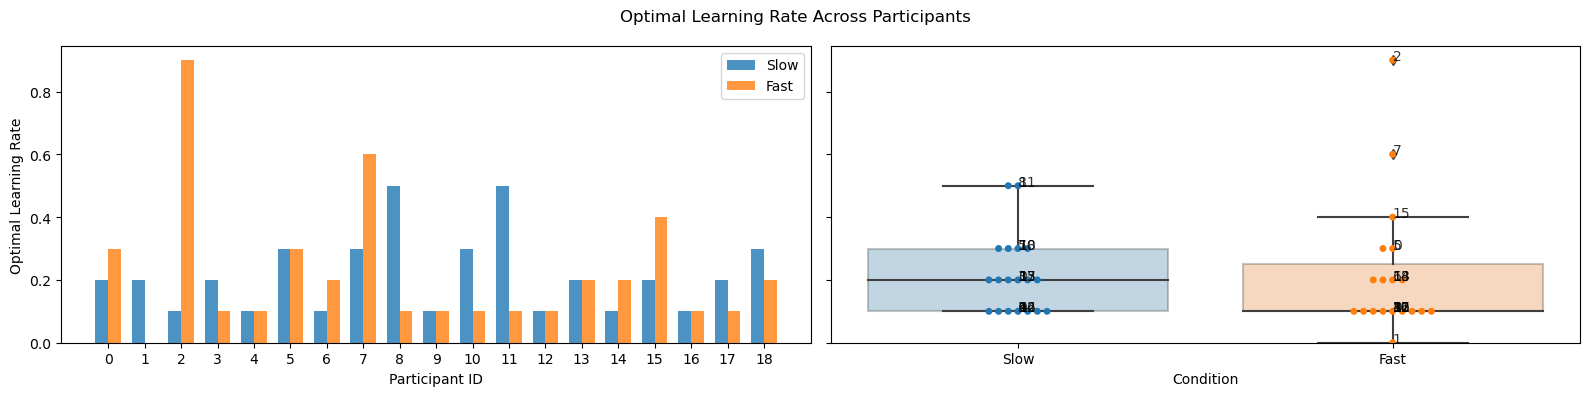

In [420]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Learning Rate Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, optimal_model_params_rw_slow[:, 0], 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, optimal_model_params_rw_fast[:, 0], 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Learning Rate')

boxplots([optimal_model_params_rw_slow, optimal_model_params_rw_fast], ('Slow', 'Fast'), ax[1])
ax[1].set_xlabel('Condition')
plt.tight_layout()

In [172]:
st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])

Ttest_relResult(statistic=-0.17613034324107515, pvalue=0.8622726485067128)

The two-sample $t$-test for paired samples reveal that there isn't a significant effect, $t$(17) = -0.176, $p$ = 0.862, of the time-pressure on the learning. 

#### Does time pressure lead to more noisy decisions?

Compare $\epsilon$-error parameter in slow vs fast tasks.

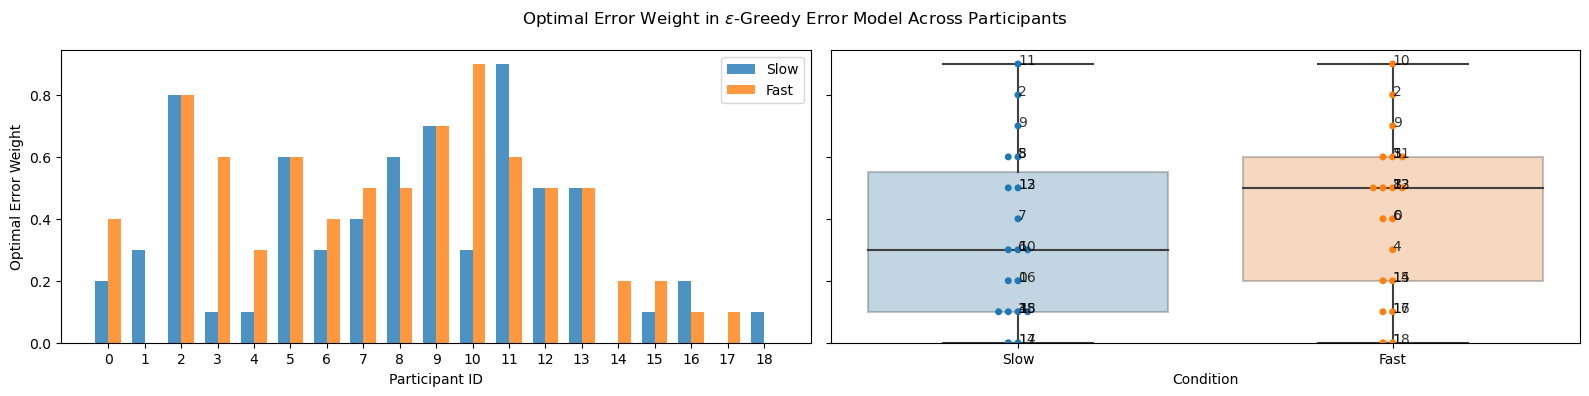

In [421]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, optimal_error_rw_slow, 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, optimal_error_rw_fast, 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Error Weight')

boxplots([optimal_error_rw_slow, optimal_error_rw_fast], ('Slow', 'Fast'), ax[1])
ax[1].set_xlabel('Condition')
plt.tight_layout()

In [133]:
st.ttest_rel(optimal_error_rw_slow[:18], optimal_error_rw_fast[:18])

Ttest_relResult(statistic=-1.3497457427492607, pvalue=0.19479792642124882)

The two-sample $t$-test for paired samples reveal that there isn't a significant effect, $t$(17) = -1.350, $p$ = 0.195, of the time-pressure on the noisiness of the decisions. 

### Kalman Filter

In [65]:
class KalmanFilter():
    _num_params = 2 
    
    def __init__(self, num_features, sigma_y, sigma_w):
        self.num_features = num_features
        self.sigma_y = sigma_y
        self.sigma_w = sigma_w
        
        self.weights = np.zeros((num_features, 1))
        self.covariance = sigma_w * np.eye(num_features)
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        std = np.sqrt(inputs.T @ self.covariance @ inputs + self.sigma_y ** 2)
        return mean, std

    def learn(self, inputs, targets):
        kalman_numerator = self.covariance @ inputs
        kalman_denominator = inputs.T @ self.covariance @ inputs + self.sigma_y ** 2
        kalman_gain = kalman_numerator / kalman_denominator
        
        self.weights = self.weights + kalman_gain * (targets - self.weights.T @ inputs)
        self.covariance = self.covariance - kalman_gain @ inputs.T @ self.covariance

In [67]:
# bics_kf_slow, optimal_model_params_kf_slow, optimal_error_kf_slow = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)), conditions={'slow': 1})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:23:57<00:00, 265.11s/it]


In [68]:
# bics_kf_fast, optimal_model_params_kf_fast, optimal_error_kf_fast = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)), conditions={'slow': 0})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:23:01<00:00, 262.18s/it]


##### Save Pickles

In [390]:
# save('bics_kf_slow')
# save('optimal_model_params_kf_slow')
# save('optimal_error_kf_slow')

In [391]:
# save('bics_kf_fast')
# save('optimal_model_params_kf_fast')
# save('optimal_error_kf_fast')

##### Load Pickles

In [ ]:
bics_kf_slow = load('bics_kf_slow')
optimal_model_params_kf_slow = load('optimal_model_params_kf_slow')
optimal_error_kf_slow = load('optimal_error_kf_slow')

In [ ]:
bics_kf_fast = load('bics_kf_fast')
optimal_model_params_kf_fast = load('optimal_model_params_kf_fast')
optimal_error_kf_fast = load('optimal_error_kf_fast')

#### Does time pressure lead to slower learning?

Compare $\sigma_y$ in slow vs fast tasks.

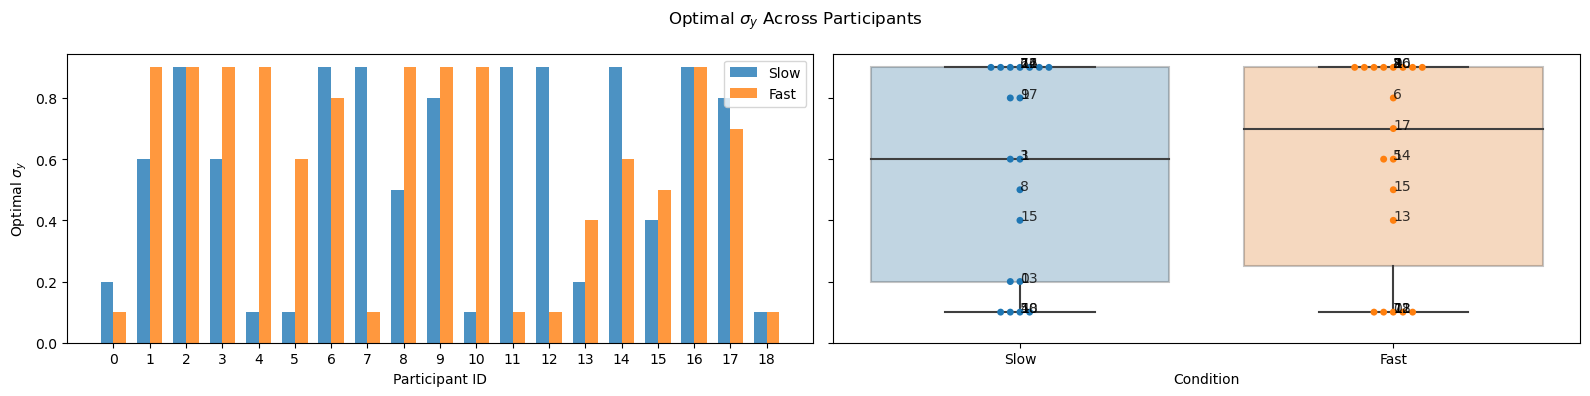

In [422]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal $\sigma_y$ Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, optimal_model_params_kf_slow[:, 0], 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, optimal_model_params_kf_fast[:, 0], 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel(r'Optimal $\sigma_y$')

boxplots([optimal_model_params_kf_slow[:, 0], optimal_model_params_kf_fast[:, 0]], ('Slow', 'Fast'), ax[1])
ax[1].set_xlabel('Condition')
plt.tight_layout()

In [143]:
st.ttest_rel(optimal_model_params_kf_slow[:18, 0], optimal_model_params_kf_fast[:18, 0])

Ttest_relResult(statistic=-0.24430028416738164, pvalue=0.8099224118645773)

The two-sample $t$-test for paired samples reveal that there isn't a significant effect, $t$(17) = -0.244, $p$ = 0.810, of the time-pressure on the learning. 

#### Does time pressure lead to more noisy decisions?

Compare $\epsilon$-error parameter in slow vs fast tasks.

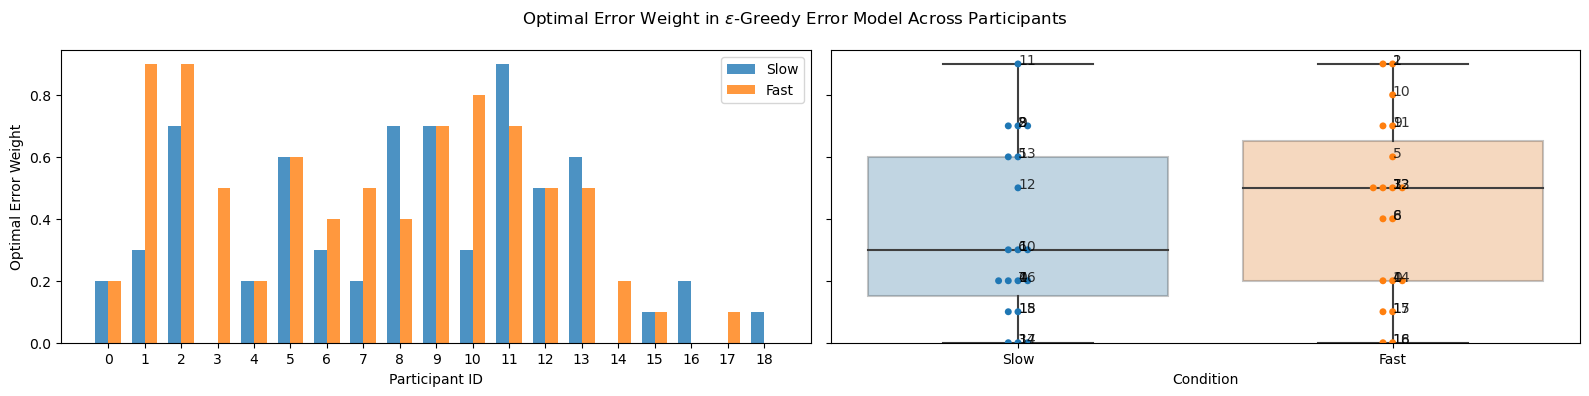

In [423]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, np.array(optimal_error_kf_slow).squeeze(), 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, np.array(optimal_error_kf_fast).squeeze(), 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Error Weight')

boxplots([optimal_error_kf_slow, optimal_error_kf_fast], ('Slow', 'Fast'), ax[1])
ax[1].set_xlabel('Condition')
plt.tight_layout()

In [144]:
st.ttest_rel(optimal_error_kf_slow[:18], optimal_error_kf_fast[:18])

Ttest_relResult(statistic=-1.5975630792578401, pvalue=0.12856008111840242)

The two-sample $t$-test for paired samples reveal that there isn't a significant effect, $t$(17) = -1.160, $p$ = 0.129, of the time-pressure on the noisiness of the decisions. 

### Random Model

In [73]:
# bics_rm = np.array([bic(0, NUM_TRIALS*data['global_task'].nunique(), NUM_TRIALS*data['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [74]:
bics_rm_slow = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [75]:
bics_rm_fast = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

## Model Comparison

<div class="alert alert-success">
    Choosing BIC as performance measure because the aim is to have the best fitting model or highest posterior probability.
</div>

In [163]:
bics_slow = pd.DataFrame({'RW_SLOW': bics_rw_slow, 'KF_SLOW': bics_kf_slow, 'RM_SLOW': bics_rm_slow})
bics_fast = pd.DataFrame({'RW_FAST': bics_rw_fast, 'KF_FAST': bics_kf_fast, 'RM_FAST': bics_rm_fast})

In [164]:
bics_net = pd.DataFrame({m: bics_slow[f'{m}_SLOW'] + bics_fast[f'{m}_FAST'] - p*np.log(300) for m, p in zip(['RW', 'KF', 'RM'], [2, 3, 0])})

In [190]:
counts_slow = {'RW_SLOW': 0, 'KF_SLOW': 0, 'RM_SLOW': 0}
for key, val in zip(*np.unique(bics_slow.columns[np.argmin(np.array(bics_slow[:18]), axis=1)], return_counts=True)):
    counts_slow[key] = val

counts_fast = {'RW_FAST': 0, 'KF_FAST': 0, 'RM_FAST': 0}
for key, val in zip(*np.unique(bics_fast.columns[np.argmin(np.array(bics_fast[:18]), axis=1)], return_counts=True)):
    counts_fast[key] = val

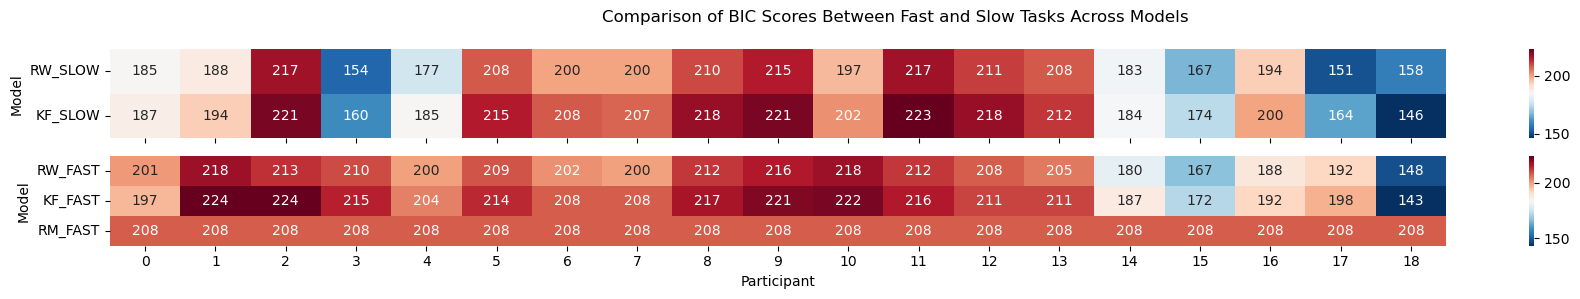

In [166]:
fig, axs = plt.subplots(2, 1, figsize=(18, 3), sharex=True)

sns.heatmap(bics_slow.applymap(round)[['RW_SLOW', 'KF_SLOW']].T, cmap='RdBu_r', annot=True, fmt='g', ax=axs[0])
# axs[0].set_title('BIC (Slow Tasks)')
# axs[0].set_xlabel('Participant')
axs[0].set_ylabel('Model')

sns.heatmap(bics_fast.applymap(round)[['RW_FAST', 'KF_FAST', 'RM_FAST']].T, cmap='RdBu_r', annot=True, fmt='g', ax=axs[1])
# axs[1].set_title('BIC (Fast Tasks)')
axs[1].set_xlabel('Participant')
axs[1].set_ylabel('Model')

fig.suptitle('Comparison of BIC Scores Between Fast and Slow Tasks Across Models')

plt.tight_layout()

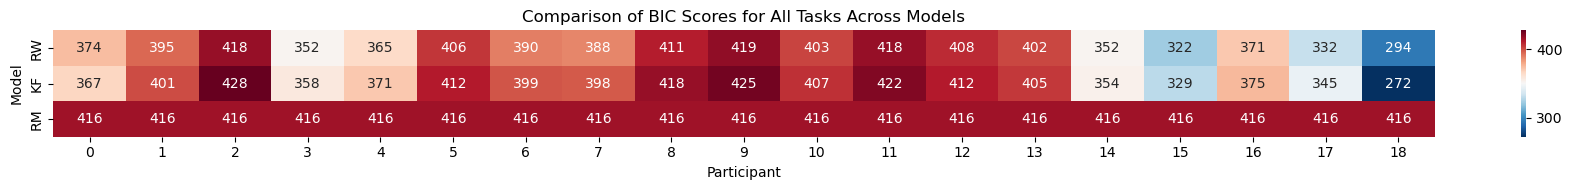

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2), sharex=True)

sns.heatmap(bics_net.applymap(round)[['RW', 'KF', 'RM']].T, cmap='RdBu_r', annot=True, fmt='g', ax=ax)
ax.set_xlabel('Participant')
ax.set_ylabel('Model')

ax.set_title('Comparison of BIC Scores for All Tasks Across Models')

plt.tight_layout()

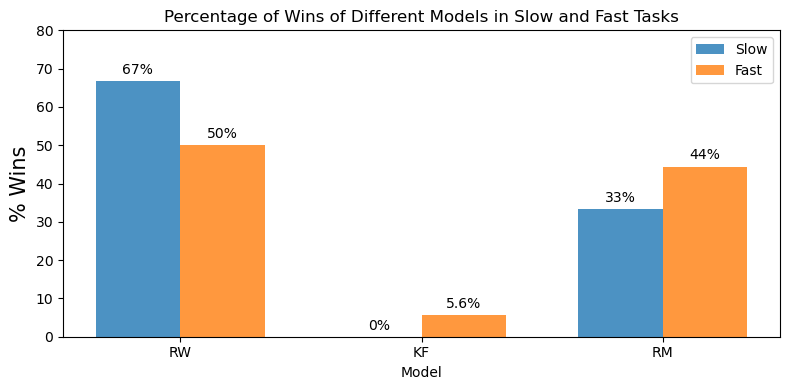

In [409]:
plt.figure(figsize=(8, 4))

plt.bar_label(plt.bar(np.arange(len(counts_slow)) - 0.175, list(counts_slow.values())/sum(list(counts_slow.values()))*np.float64(100), 0.35, label='Slow', alpha=0.8), fmt='%0.2g%%', padding=3)
plt.bar_label(plt.bar(np.arange(len(counts_fast)) + 0.175, list(counts_fast.values())/sum(list(counts_fast.values()))*np.float64(100), 0.35, label='Fast', alpha=0.8), fmt='%0.2g%%', padding=3)

plt.xticks(range(len(counts_slow)), ['RW', 'KF', 'RM'])

plt.ylim((0, 80))

plt.xlabel('Model')
plt.ylabel('% Wins', fontsize=15);

plt.legend()

plt.title('Percentage of Wins of Different Models in Slow and Fast Tasks')
plt.tight_layout()

#### Which model explains the human data best?

The comparison of percentages of wins based on the BIC scores shows that the Rescorla Wagner model explains the human data best, with and without time pressure (\~67% without time pressure and \~50% with time pressure), followed by the random model (\~33% without time pressure and \~44% with time pressure).

For participant 18 in particular, the Kalman Filter atypically model performs best. This is expected because this participant was an ideal particiant (a bot) that indeed employed Kalman Filter to learn, but the BIC score is not too low in comparison because there was some artificial randomness added for realism, and so the $\epsilon$ error value for the best fitting Kalman Filter model is not zero either. The parameter fitting resulted in almost the same parameters ($\sigma_y$ = 0.1, $\sigma_w$ = 0.9) of the Kalman Filter model that the bot employed ($\sigma_y$ = 0.1, $\sigma_w$ = 1). ($\sigma_w$ is not the same because $\sigma_w$ > 0.9 was not included in the search space [0, 0.9]).

#### Does time pressure lead to simpler learning strategies?

<Compare the complexity of models based on percentage of wins in slow vs fast tasks.>
The comparison of wins based on the BIC scores scores shows that participants use random policy more often than a structured learning strategy under time pressure.

## Additional Analysis

`SLOW`

In [290]:
# bics_rw_slow_2, optimal_model_params_rw_slow_2, optimal_error_rw_slow_2 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 1, 'num_features': 2})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [04:05<00:00, 12.94s/it]


In [194]:
# bics_rw_slow_3, optimal_model_params_rw_slow_3, optimal_error_rw_slow_3 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 1, 'num_features': 3})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:42<00:00, 11.72s/it]


In [195]:
# bics_rw_slow_4, optimal_model_params_rw_slow_4, optimal_error_rw_slow_4 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 1, 'num_features': 4})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:41<00:00, 11.68s/it]


`FAST`

In [196]:
# bics_rw_fast_2, optimal_model_params_rw_fast_2, optimal_error_rw_fast_2 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 0, 'num_features': 2})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:44<00:00, 11.79s/it]


In [197]:
# bics_rw_fast_3, optimal_model_params_rw_fast_3, optimal_error_rw_fast_3 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 0, 'num_features': 3})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:42<00:00, 11.72s/it]


In [198]:
# bics_rw_fast_4, optimal_model_params_rw_fast_4, optimal_error_rw_fast_4 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 0, 'num_features': 4})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:45<00:00, 11.85s/it]


##### Save Pickles

In [393]:
# save('bics_rw_slow_2')
# save('optimal_model_params_rw_slow_2')
# save('optimal_error_rw_slow_2')

# save('bics_rw_slow_3')
# save('optimal_model_params_rw_slow_3')
# save('optimal_error_rw_slow_3')

# save('bics_rw_slow_4')
# save('optimal_model_params_rw_slow_4')
# save('optimal_error_rw_slow_4')

In [394]:
# save('bics_rw_fast_2')
# save('optimal_model_params_rw_fast_2')
# save('optimal_error_rw_fast_2')

# save('bics_rw_fast_3')
# save('optimal_model_params_rw_fast_3')
# save('optimal_error_rw_fast_3')

# save('bics_rw_fast_4')
# save('optimal_model_params_rw_fast_4')
# save('optimal_error_rw_fast_4')

##### Load Pickles

In [390]:
bics_rw_slow_2 = load('bics_rw_slow_2')
optimal_model_params_rw_slow_2 = load('optimal_model_params_rw_slow_2')
optimal_error_rw_slow_2 = load('optimal_error_rw_slow_2')

bics_rw_slow_3 = load('bics_rw_slow_3')
optimal_model_params_rw_slow_3 = load('optimal_model_params_rw_slow_3')
optimal_error_rw_slow_3 = load('optimal_error_rw_slow_3')

bics_rw_slow_4 = load('bics_rw_slow_4')
optimal_model_params_rw_slow_4 = load('optimal_model_params_rw_slow_4')
optimal_error_rw_slow_4 = load('optimal_error_rw_slow_4')

In [391]:
bics_rw_fast_2 = load('bics_rw_fast_2')
optimal_model_params_rw_fast_2 = load('optimal_model_params_rw_fast_2')
optimal_error_rw_fast_2 = load('optimal_error_rw_fast_2')

bics_rw_fast_3 = load('bics_rw_fast_3')
optimal_model_params_rw_fast_3 = load('optimal_model_params_rw_fast_3')
optimal_error_rw_fast_3 = load('optimal_error_rw_fast_3')

bics_rw_fast_4 = load('bics_rw_fast_4')
optimal_model_params_rw_fast_4 = load('optimal_model_params_rw_fast_4')
optimal_error_rw_fast_4 = load('optimal_error_rw_fast_4')

#### Does increasing the number of features lead to slower learning?

`SLOW`

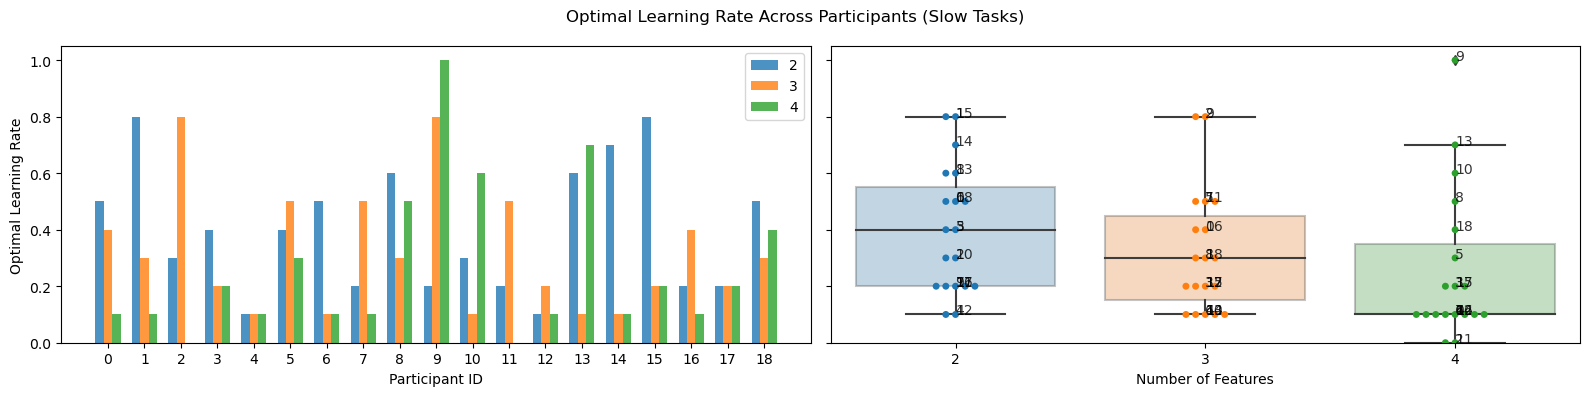

In [404]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Learning Rate Across Participants (Slow Tasks)')
ax[0].bar(PARTICIPANTS - 0.23, optimal_model_params_rw_slow_2[:, 0], 0.23, label='2', alpha=0.8)
ax[0].bar(PARTICIPANTS, optimal_model_params_rw_slow_3[:, 0], 0.23, label='3', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.23, optimal_model_params_rw_slow_4[:, 0], 0.23, label='4', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Learning Rate')

boxplots([optimal_model_params_rw_slow_2, optimal_model_params_rw_slow_3, optimal_model_params_rw_slow_4], ('2', '3', '4'), ax[1])
ax[1].set_xlabel('Number of Features')
plt.tight_layout()

In [279]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='learning_rate ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_model_params_rw_slow_2), [3]*len(optimal_model_params_rw_slow_3), [4]*len(optimal_model_params_rw_slow_4)]),
            'learning_rate': np.concatenate([optimal_model_params_rw_slow_2[:, 0], optimal_model_params_rw_slow_3[:, 0], optimal_model_params_rw_slow_4[:, 0]])
        })).fit().summary();

The number of features does not have a significant influence on the learning rate ($\beta$ = -0.071, $R^2$ = 0.059, $p$ = 0.070).

`FAST`

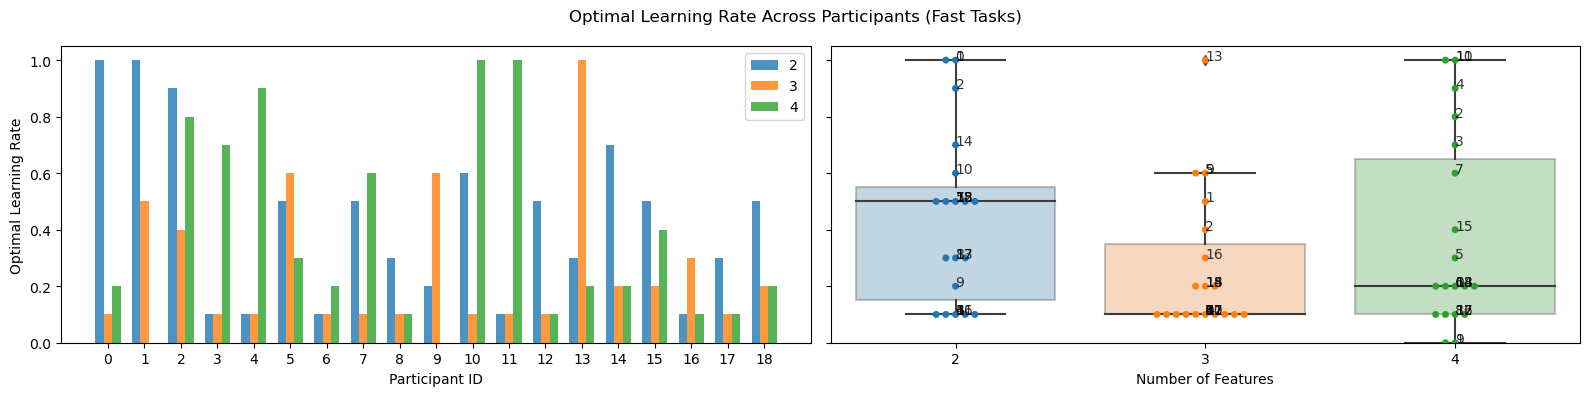

In [406]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Learning Rate Across Participants (Fast Tasks)')
ax[0].bar(PARTICIPANTS - 0.23, optimal_model_params_rw_fast_2[:, 0], 0.23, label='2', alpha=0.8)
ax[0].bar(PARTICIPANTS, optimal_model_params_rw_fast_3[:, 0], 0.23, label='3', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.23, optimal_model_params_rw_fast_4[:, 0], 0.23, label='4', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Learning Rate')

boxplots([optimal_model_params_rw_fast_2, optimal_model_params_rw_fast_3, optimal_model_params_rw_fast_4], ('2', '3', '4'), ax[1])
ax[1].set_xlabel('Number of Features')
plt.tight_layout()

In [288]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='learning_rate ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_model_params_rw_fast_2), [3]*len(optimal_model_params_rw_fast_3), [4]*len(optimal_model_params_rw_fast_4)]),
            'learning_rate': np.concatenate([optimal_model_params_rw_fast_2[:, 0], optimal_model_params_rw_fast_3[:, 0], optimal_model_params_rw_fast_4[:, 0]])
        })).fit().summary();

The number of features does not have a significant influence on the learning rate ($\beta$ = -0.032, $R^2$ = 0.007, $p$ = 0.528).

#### Does increasing the number of features lead to noisy decisions?

`SLOW`

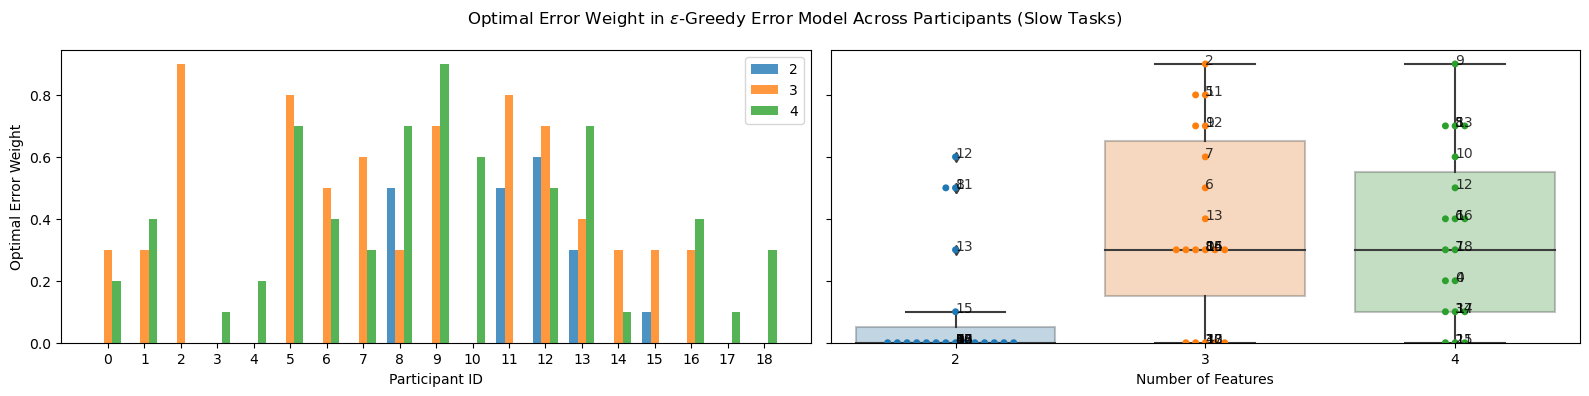

In [402]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants (Slow Tasks)')
ax[0].bar(PARTICIPANTS - 0.23, optimal_error_rw_slow_2, 0.23, label='2', alpha=0.8)
ax[0].bar(PARTICIPANTS, optimal_error_rw_slow_3, 0.23, label='3', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.23, optimal_error_rw_slow_4, 0.23, label='4', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Error Weight')

boxplots([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4], ('2', '3', '4'), ax[1])
ax[1].set_xlabel('Number of Features')
plt.tight_layout()

In [315]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='epsilon_error ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_error_rw_slow_2), [3]*len(optimal_error_rw_slow_3), [4]*len(optimal_error_rw_slow_4)]),
            'epsilon_error': np.concatenate([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4])
        })).fit().summary();

The number of features has a significant influence on the noisiness of the decisions ($\beta$ = 0.121, $R^2$ = 0.121, $p$ = 0.008), with the addition of each feature increasing noisiness on average by 0.121.

In [313]:
pairwise_tukeyhsd(np.concatenate([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4]),
                  np.concatenate([[2]*len(optimal_error_rw_slow_2), [3]*len(optimal_error_rw_slow_3), [4]*len(optimal_error_rw_slow_4)])).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
2,3,0.2737,0.0065,0.0671,0.4802,True
2,4,0.2421,0.0179,0.0356,0.4487,True
3,4,-0.0316,0.928,-0.2381,0.175,False


`FAST`

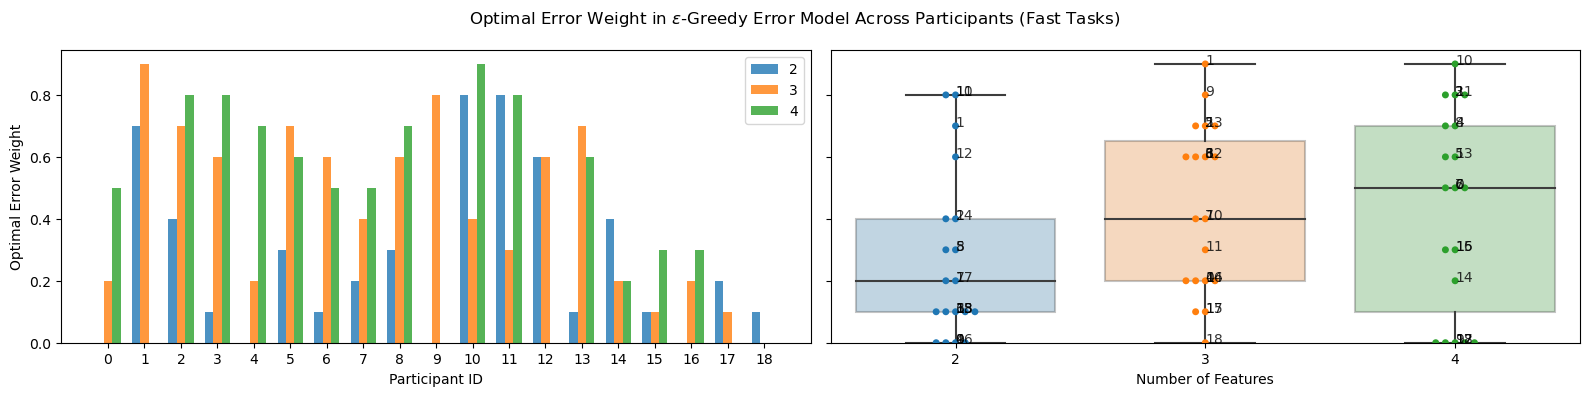

In [407]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants (Fast Tasks)')
ax[0].bar(PARTICIPANTS - 0.23, optimal_error_rw_fast_2, 0.23, label='2', alpha=0.8)
ax[0].bar(PARTICIPANTS, optimal_error_rw_fast_3, 0.23, label='3', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.23, optimal_error_rw_fast_4, 0.23, label='4', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Error Weight')

boxplots([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4], ('2', '3', '4'), ax[1])
ax[1].set_xlabel('Number of Features')
plt.tight_layout()

In [316]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='epsilon_error ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_error_rw_fast_2), [3]*len(optimal_error_rw_fast_3), [4]*len(optimal_error_rw_fast_4)]),
            'epsilon_error': np.concatenate([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4])
        })).fit().summary();

The number of features does not have a significant influence on the noisiness of the decisions ($\beta$ = 0.079, $R^2$ = 0.049, $p$ = 0.099).

In [318]:
pairwise_tukeyhsd(np.concatenate([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4]),
                  np.concatenate([[2]*len(optimal_error_rw_fast_2), [3]*len(optimal_error_rw_fast_3), [4]*len(optimal_error_rw_fast_4)])).summary();

## Miscellaneous

### Comparison of Speed/Accuracy of Optimisation Techniques

In [354]:
# bics_rw_slow_2_nm, optimal_model_params_rw_slow_2_nm, optimal_error_rw_slow_2_nm = optimise(RescorlaWagner,
#                             model_search_space=(0.5,),
#                             error_search_space=0.1,
#                             conditions={'slow': 1, 'num_features': 2},
#                             search_algorithm=lambda *args, **kwargs: [optimize.minimize(*args, **kwargs, bounds=((0, 1), (0, 1)), method='Nelder-Mead')[key] for key in ['x', 'fun']])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [04:32<00:00, 14.34s/it]


`Save Pickles`

In [395]:
# save('bics_rw_slow_2_nm')
# save('optimal_model_params_rw_slow_2_nm')
# save('optimal_error_rw_slow_2_nm')

`Load Pickles`

In [390]:
bics_rw_slow_2_nm = load('bics_rw_slow_2_nm')
optimal_model_params_rw_slow_2_nm = load('optimal_model_params_rw_slow_2_nm')
optimal_error_rw_slow_2_nm = load('optimal_error_rw_slow_2_nm')

In [ ]:
np.mean(abs(bics_rw_slow_2_nm - bics_rw_slow_2))

0.4230812774305918

The difference in optimum BIC scores of Nelder-Mead optimisation and Grid Search optimisation is minimal. But gradient descent optimisation takes more time for 100 iterations than Grid Search for a sufficiently fine grid (10 divisions), so we used Grid Search for our analyses.

# Methods

# Results

# Discussion

# References